# Chapter 14: Deep Computer Vision Using Convolutional Neural Networks

This notebook contains the code reproductions and theoretical explanations for Chapter 14 of *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*.

## Chapter Summary

This chapter introduces **Convolutional Neural Networks (CNNs)**, the architecture that powers modern computer vision.

Key topics covered include:

* **The Visual Cortex:** Inspiration for CNNs is drawn from the hierarchical architecture of the visual cortex, with its local receptive fields.
* **Convolutional Layers:** The core building block of CNNs. We learn how they work using **filters** (or kernels) that detect local patterns. We explore key hyperparameters like **padding** (`"valid"` vs. `"same"`) and **stride**.
* **Pooling Layers:** Used to subsample (shrink) the feature maps, reducing computational load, memory usage, and the number of parameters, which helps limit overfitting. We cover **max pooling** and **global average pooling**.
* **CNN Architectures:** We assemble convolutional and pooling layers to build a simple CNN. We then explore the history and architecture of several landmark models:
    * **LeNet-5:** The pioneering CNN for digit recognition.
    * **AlexNet:** The model that won the 2012 ImageNet challenge and proved the power of deep CNNs.
    * **GoogLeNet:** Introduced the *inception module*, allowing for much deeper and more efficient networks.
    * **ResNet:** Introduced the *residual unit* (or skip connection), which made it possible to train extremely deep networks (e.g., 152 layers) by tackling the vanishing gradient problem.
    * **Xception & SENet:** More recent architectures that introduced *depthwise separable convolutions* and *squeeze-and-excitation* blocks for even better performance and efficiency.
* **Transfer Learning:** How to use pretrained models from `keras.applications` (like ResNet-50) to build powerful image classifiers for new tasks, even with little data.
* **Other CV Tasks:** We go beyond simple classification to look at:
    * **Classification and Localization:** Predicting both the class *and* a bounding box for a single object.
    * **Object Detection:** Using Fully Convolutional Networks (FCNs) and architectures like YOLO (You Only Look Once) to detect multiple objects in an image.
    * **Semantic Segmentation:** Classifying every single pixel in an image to identify which object it belongs to, using an FCN with upsampling (transposed convolutional layers).

## Setup

First, let's import the necessary libraries and set up the environment.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

# Common setup for plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Convolutional Layers

### Theoretical Explanation

The **convolutional layer** is the most important building block of a CNN.

1.  **Local Receptive Fields:** Unlike neurons in a dense layer, neurons in a convolutional layer are not connected to every pixel in the input image. Instead, they are connected only to a small rectangular region of the previous layer, known as their **receptive field**.
2.  **Filters (or Kernels):** A neuron's weights form a small image the size of the receptive field. This set of weights is called a **filter**. A filter is slid across the entire input image, producing a **feature map**. This feature map highlights the areas of the image that activate the filter (e.g., a filter might detect vertical edges, another horizontal edges, etc.).
3.  **Weight Sharing:** All neurons in a single feature map share the *same* filter (weights and bias). This dramatically reduces the number of parameters in the model and makes it so that a pattern learned in one part of the image can be detected in any other part.
4.  **Padding:** To ensure the output feature map has the same spatial dimensions (height/width) as the input, we often add zeros around the input, a technique called **zero padding**. In Keras, this is set by `padding="same"`. The alternative, `padding="valid"`, means no padding is applied, so the feature map will be smaller.
5.  **Stride:** The **stride** is the step (in pixels) the filter takes as it slides across the image. A stride of 1 means the filter shifts one pixel at a time. A stride of 2 means it shifts two pixels, resulting in a feature map that is half the height and width.
6.  **Multiple Channels:** An input image typically has 3 color channels (RGB). A convolutional layer applies its filters across all input channels. If the layer has *n* filters, it will output *n* feature maps. These feature maps form the input for the next layer.

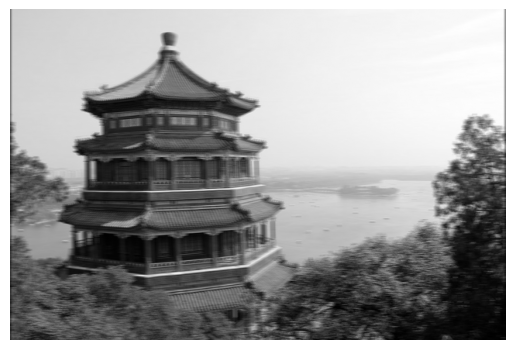

In [2]:
# Load sample images
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

# Apply the filters using the low-level tf.nn.conv2d() function
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

# Plot the second feature map of the first image (the horizontal line filter)
plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off")
plt.show()

In [3]:
# In Keras, you use the Conv2D layer
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                             padding="same", activation="relu")

## Pooling Layers

### Theoretical Explanation

The goal of **pooling layers** is to **subsample** (shrink) the feature maps. This reduces computational load, memory usage, and the number of parameters, thus limiting the risk of overfitting.

A pooling layer works similarly to a convolutional layer: it has a kernel of a certain size and a stride, and it slides over its input. However, it has no weights. It simply aggregates the inputs in its receptive field using an aggregation function.

* **Max Pooling (`MaxPool2D`):** This is the most common type. It takes the *maximum* value from its receptive field. This "survives" only the strongest activations, discarding the weaker ones. It also provides a small amount of **translation invariance** (a pattern shifted by one pixel will still produce the same max value).
* **Average Pooling (`AvgPool2D`):** Takes the *average* value. This was more common in the past but has generally been replaced by max pooling.
* **Global Average Pooling (`GlobalAvgPool2D`):** A special type that computes the average of the *entire* feature map. It outputs a single number per feature map. This is often used as the final layer before the output Dense layer, as it's a very efficient way to reduce the dimensionality to a simple vector of features without many parameters.

In [4]:
# Max Pooling Layer
# A 2x2 pool size with a stride of 2 (default) will reduce the image dimensions by half.
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [5]:
# Global Average Pooling Layer
global_avg_pool = keras.layers.GlobalAvgPool2D()

## CNN Architectures

A typical CNN architecture stacks a few convolutional layers (each followed by a ReLU), then a pooling layer, then another set of convolutional layers (+ReLU), then another pooling layer, and so on. As the image progresses, it gets smaller, but it also gets *deeper* (i.e., has more feature maps). At the top, a `Flatten` layer is used to convert the 3D feature maps into a 1D vector, which is then fed into a standard feedforward network (Dense layers) for classification.

In [6]:
# Building a simple CNN for Fashion MNIST (assuming X_train is loaded and preprocessed)
# (We'll load the data properly in the transfer learning section)

model = keras.models.Sequential([
    # Note: Fashion MNIST images are 28x28 grayscale (1 channel)
    keras.layers.Conv2D(64, 7, activation="relu", padding="same",
                          input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,413,834 (5.39 MB)

 Trainable params: 1,413,834 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

### LeNet-5, AlexNet, GoogLeNet, VGGNet

The book describes these foundational architectures.
* **LeNet-5 (1998):** The pioneer, used for digit recognition. It used `tanh` activations and average pooling.
* **AlexNet (2012):** Won ImageNet. Was much larger and deeper, used `ReLU`, and stacked convolutional layers directly. Also used dropout and data augmentation.
* **GoogLeNet (2014):** Introduced *inception modules*, which are blocks of parallel convolutional layers with different kernel sizes (1x1, 3x3, 5x5). This allowed it to be much deeper and more parameter-efficient than AlexNet.
* **VGGNet (2014):** A very simple and uniform architecture, using only 3x3 filters stacked on top of each other. Its depth (16-19 layers) was its main contribution.

### ResNet

**Theoretical Explanation:**

The **Residual Network (ResNet)**, introduced in 2015, made it possible to train truly deep networks (152 layers and more). Its key innovation is the **residual unit** (or skip connection).

The problem with very deep nets is that gradients can vanish or explode. A skip connection addresses this by adding the input of a block to its output (`F(x) + x`). When the network is initialized, the weights of the block (`F(x)`) are small, so the block just outputs its input (`x`). This allows the network to learn the *identity function* easily, and gradients can flow "skipped" across the block. The network is then trained to learn the *residual* (`h(x) - x`), which is often easier to learn than the full function `h(x)`.

In [7]:
# Implementation of a ResNet-34 Residual Unit (RU)
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides,
                                    padding="same", use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)


In [8]:
# Building a full ResNet-34 model
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3],
                              padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

### Using Pretrained Models from Keras

It is almost always preferable to use a model pretrained on a large dataset (like ImageNet) rather than training a model from scratch. `keras.applications` provides many popular architectures.

In [9]:
# Load a ResNet-50 model, pretrained on ImageNet
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
# Resize the sample images to 224x224 (as ResNet expects)
images_resized = tf.image.resize(images, [224, 224])

# Preprocess the images using the model's specific preprocess_input function
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

# Make predictions
Y_proba = model.predict(inputs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [11]:
# Decode the predictions to get the top 3 class names
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Image #0
  n02825657 - bell_cote    82.35%
  n03877845 - palace       6.75%
  n03781244 - monastery    4.19%

Image #1
  n03530642 - honeycomb    49.81%
  n13040303 - stinkhorn    33.96%
  n02206856 - bee          4.35%



### Pretrained Models for Transfer Learning

**Theoretical Explanation:**

**Transfer learning** is the most common and effective use of pretrained models. Instead of training a model from scratch for a new task (e.g., classifying flowers), we use a base model (like Xception) that was already trained on a large, general dataset (like ImageNet).

This base model has already learned powerful feature detectors (edges, shapes, textures, etc.) in its lower layers. We can reuse these layers and just replace the top layer with a new one (e.g., a Dense layer with 5 units for 5 flower classes).

The process is:
1.  Load a pretrained base model (e.g., Xception) with `include_top=False`. This cuts off the original top classification layer.
2.  **Freeze** the weights of the base model's layers (`layer.trainable = False`).
3.  Add your new output layers on top (e.g., a `GlobalAveragePooling2D` layer followed by a `Dense` layer).
4.  Compile and train the model for a few epochs. This trains *only* your new output layers, allowing them to learn how to use the features from the base model.
5.  **Unfreeze** some or all of the base model's layers (`layer.trainable = True`).
6.  Re-compile the model with a very low learning rate (to avoid damaging the pretrained weights) and train for a few more epochs to fine-tune the entire network.

In [13]:
import tensorflow_datasets as tfds

# Load the dataset and info, as_supervised=True returns (image, label) pairs
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples # 3670
class_names = info.features["label"].names # ['dandelion', 'daisy', ...]
n_classes = info.features["label"].num_classes # 5

# Split the dataset manually since tfds.Split.TRAIN.subsplit is not available
# The original dataset has only a 'train' split, so we'll split that.

# Calculate sizes for each split
test_size = int(dataset_size * 0.10)
valid_size = int(dataset_size * 0.15)
train_size = dataset_size - test_size - valid_size

# Ensure we are using the 'train' split which contains all examples
train_data = tfds.load("tf_flowers", split='train', as_supervised=True)

# Create the splits
test_set = train_data.take(test_size)
valid_set = train_data.skip(test_size).take(valid_size)
train_set = train_data.skip(test_size + valid_size)

print(f"Dataset size: {dataset_size}")
print(f"Train set size: {tf.data.experimental.cardinality(train_set).numpy()} examples")
print(f"Validation set size: {tf.data.experimental.cardinality(valid_set).numpy()} examples")
print(f"Test set size: {tf.data.experimental.cardinality(test_set).numpy()} examples")

Dataset size: 3670
Train set size: 2753 examples
Validation set size: 550 examples
Test set size: 367 examples


In [14]:
# Create the preprocessing function
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

# Prepare the final datasets
batch_size = 32
train_set = train_set.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)

In [16]:
# 1. Load the base model without the top layer
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
# 2. Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# 3. Add our new top layers
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input,
                    outputs=[output])

# 4. Compile and train (only the new layers)
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


87/87 ━━━━━━━━━━━━━━━━━━━━ 754s 9s/step - accuracy: 0.7263 - loss: 1.2580 - val_accuracy: 0.5036 - val_loss: 8.9131
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 814s 9s/step - accuracy: 0.7234 - loss: 6.9930 - val_accuracy: 0.7655 - val_loss: 4.1755
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 748s 9s/step - accuracy: 0.8066 - loss: 4.9874 - val_accuracy: 0.8636 - val_loss: 2.8469
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 730s 8s/step - accuracy: 0.9177 - loss: 0.9980 - val_accuracy: 0.8473 - val_loss: 2.6539
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 743s 8s/step - accuracy: 0.9321 - loss: 0.6133 - val_accuracy: 0.8764 - val_loss: 2.2912


In [18]:
# 5. Unfreeze the base model
for layer in base_model.layers:
    layer.trainable = True

# 6. Re-compile with a low learning rate and fine-tune
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


87/87 ━━━━━━━━━━━━━━━━━━━━ 2721s 31s/step - accuracy: 0.7693 - loss: 0.9642 - val_accuracy: 0.7909 - val_loss: 0.7538
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 2686s 31s/step - accuracy: 0.9130 - loss: 0.2701 - val_accuracy: 0.8655 - val_loss: 0.5005
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 2736s 31s/step - accuracy: 0.9401 - loss: 0.2019 - val_accuracy: 0.8582 - val_loss: 0.4379
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 2679s 31s/step - accuracy: 0.9751 - loss: 0.0710 - val_accuracy: 0.8836 - val_loss: 0.4112
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 2694s 31s/step - accuracy: 0.9910 - loss: 0.0282 - val_accuracy: 0.8945 - val_loss: 0.4203


## Classification and Localization

**Theoretical Explanation:**

Sometimes you want to predict both the *class* of an object and its *location* (via a **bounding box**). A bounding box is typically represented by 4 numbers (e.g., horizontal coordinate, vertical coordinate, height, and width).

This becomes a multi-output model. The architecture is the same as before, but it now has two output (Dense) layers:
1.  A **classification head:** A `Dense` layer with `softmax` activation to predict the class.
2.  A **localization head:** A `Dense` layer with 4 units (and no activation) to predict the bounding box coordinates.

This model is trained with two losses—one for classification (e.g., cross-entropy) and one for localization (e.g., MSE). We can assign different weights to these losses.

In [19]:
# Re-use the model up to the avg layer
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)

# New heads
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg) # 4 units for (x, y, h, w)

# Create the new multi-output model
model = keras.Model(inputs=base_model.input,
                    outputs=[class_output, loc_output])

# Compile with two losses and loss weights
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # Weight classification more
              optimizer=optimizer,
              metrics=["accuracy"])

# To train this, you would need a dataset that yields (images, (class_labels, bboxes))
# (flower_bbox_train_set, flower_bbox_valid_set)
# history = model.fit(flower_bbox_train_set, epochs=5,
#                     validation_data=flower_bbox_valid_set)

## Object Detection & Semantic Segmentation

**Theoretical Explanation:**

* **Object Detection:** The task of classifying and localizing *multiple* objects in an image. This is much harder than localizing one object.
    * **Fully Convolutional Network (FCN):** A key idea is to replace the `Dense` layers at the top of a CNN with `Conv2D` layers. This allows the network to be *slid* across an image of any size and output a grid of predictions, making it much more efficient than running a classifier on many small patches of the image.
    * **YOLO (You Only Look Once):** A popular one-step object detection architecture. It divides the image into a grid. For each grid cell, it predicts 5 bounding boxes (plus an "objectness" score for each) and class probabilities. It's extremely fast (can run in real-time).
    * **Non-Max Suppression:** A post-processing step used to clean up the many bounding boxes predicted by an object detector. It finds the box with the highest objectness score and suppresses all other boxes that overlap significantly with it.

* **Semantic Segmentation:** The task of classifying *every pixel* in an image. For example, all pixels belonging to a car are colored blue, all pixels for a road are colored gray, etc.
    * The challenge is that regular CNNs *downsample* the image (lose spatial resolution) as it goes through pooling layers.
    * A common solution is to use an FCN (like ResNet) as an encoder, and then add an **upsampling** path (a **decoder**).
    * Upsampling is often done using a **transposed convolutional layer** (`Conv2DTranspose`), which learns to go from a small feature map to a larger one. Skip connections are also added from the encoder to the decoder to help recover the fine-grained spatial information that was lost during downsampling.